# Домашнее задание 2

В этом домашнем задании мы поупражняемся с ETS-моделью и STL-разложением. Сначала коротко про данные.

Представьте себе стандартный банкомат, который работает только на выдачу. Его нужно периодически пополнять наличностью, чтобы он функционировал непрерывно. Однако выезд инкассаторов является делом хлопотным и недешёвым, так что хотелось бы не гонять их лишний раз заполнять наполовину полный банкомат. Хотелось бы научиться предсказывать спрос людей на наличность в банкомате, чтобы можно было предсказывать время, когда количество денег в банкомате снизится до минимально допустимой величины. Этим мы и займёмся. Для простоты возьмём один конкретный банкомат. Нам доступны объёмы выдачи в банкомате по дням.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sktime.transformations.series.boxcox import BoxCoxTransformer
from statsmodels.tsa.seasonal import STL, MSTL
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

##### 1) Загрузка данных и визуальный анализ (1 балл)

Важно! sktime довольно капризен в плане форматов даты-времени. Для работы некоторых функций может требоваться PeriodIndex или DateTimeIndex. Часто самые непонятные ошибки происходят из-за этого. К сожалению, на текущий момент это данность, но мы в вас верим.

Загрузите данные из файла atm.csv. Изобразите временной ряд, его автокорреляции (можно ещё автокорреляции первых разностей для большей ясности).  Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Опишите, как сделанные вами наблюдения помогут построить модель.

In [2]:
atm_df = pd.read_csv('atm.csv')
atm_df.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
atm_df["Date"] = pd.to_datetime(atm_df["Date"])
atm_df.dtypes

Date      datetime64[ns]
target           float64
dtype: object

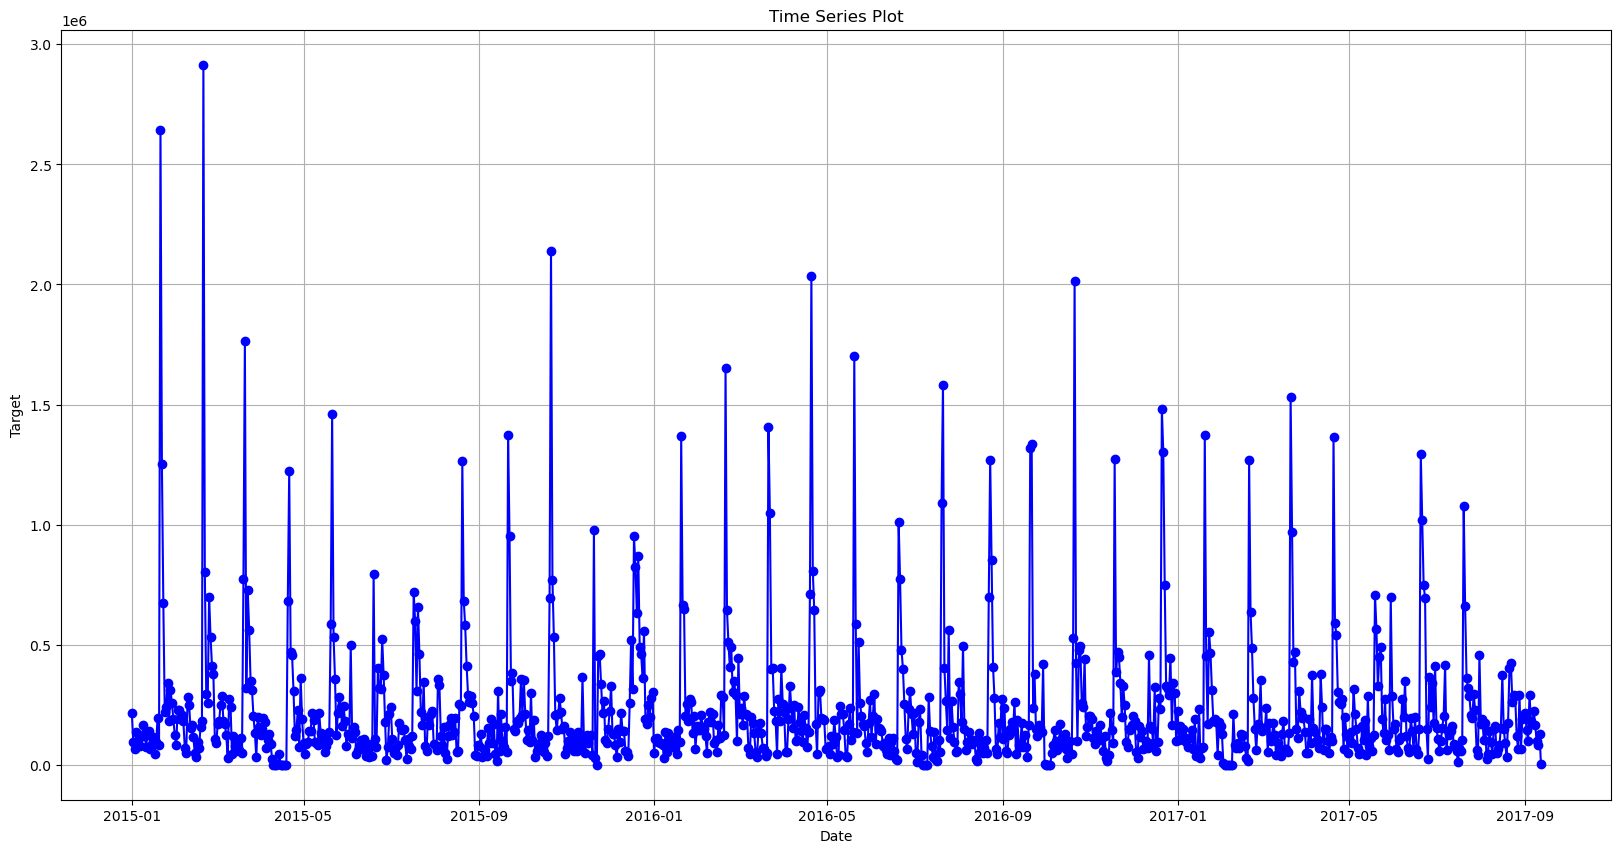

In [3]:
plt.figure(figsize=(20, 10))
plt.plot(atm_df['Date'], atm_df['target'], marker='o', linestyle='-', color='b')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Target')
plt.grid(True)
plt.show()

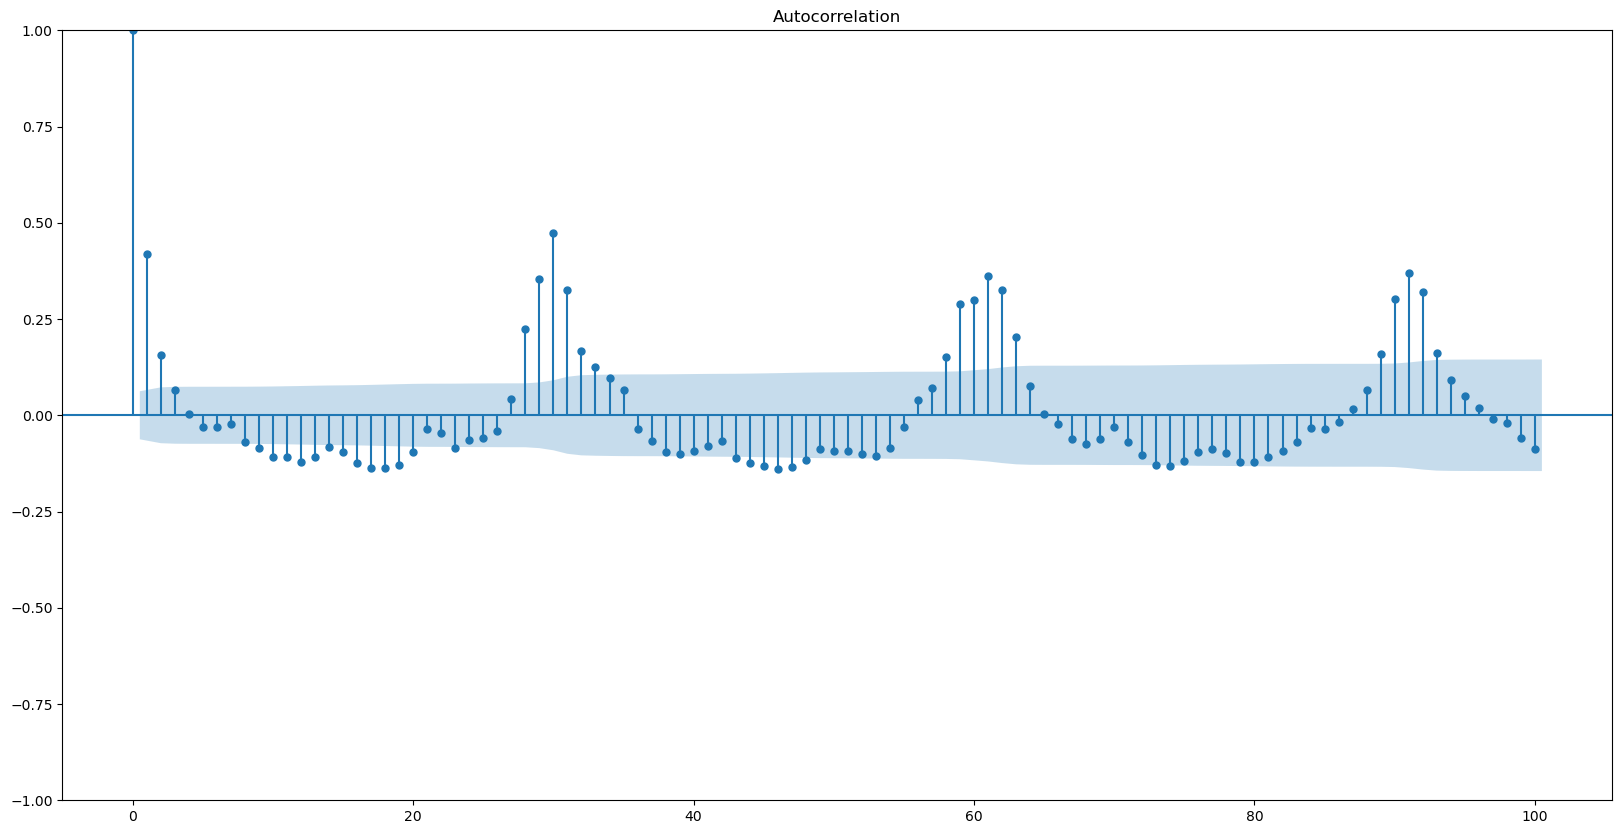

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_acf(atm_df['target'], lags=100, ax=ax)
plt.show()

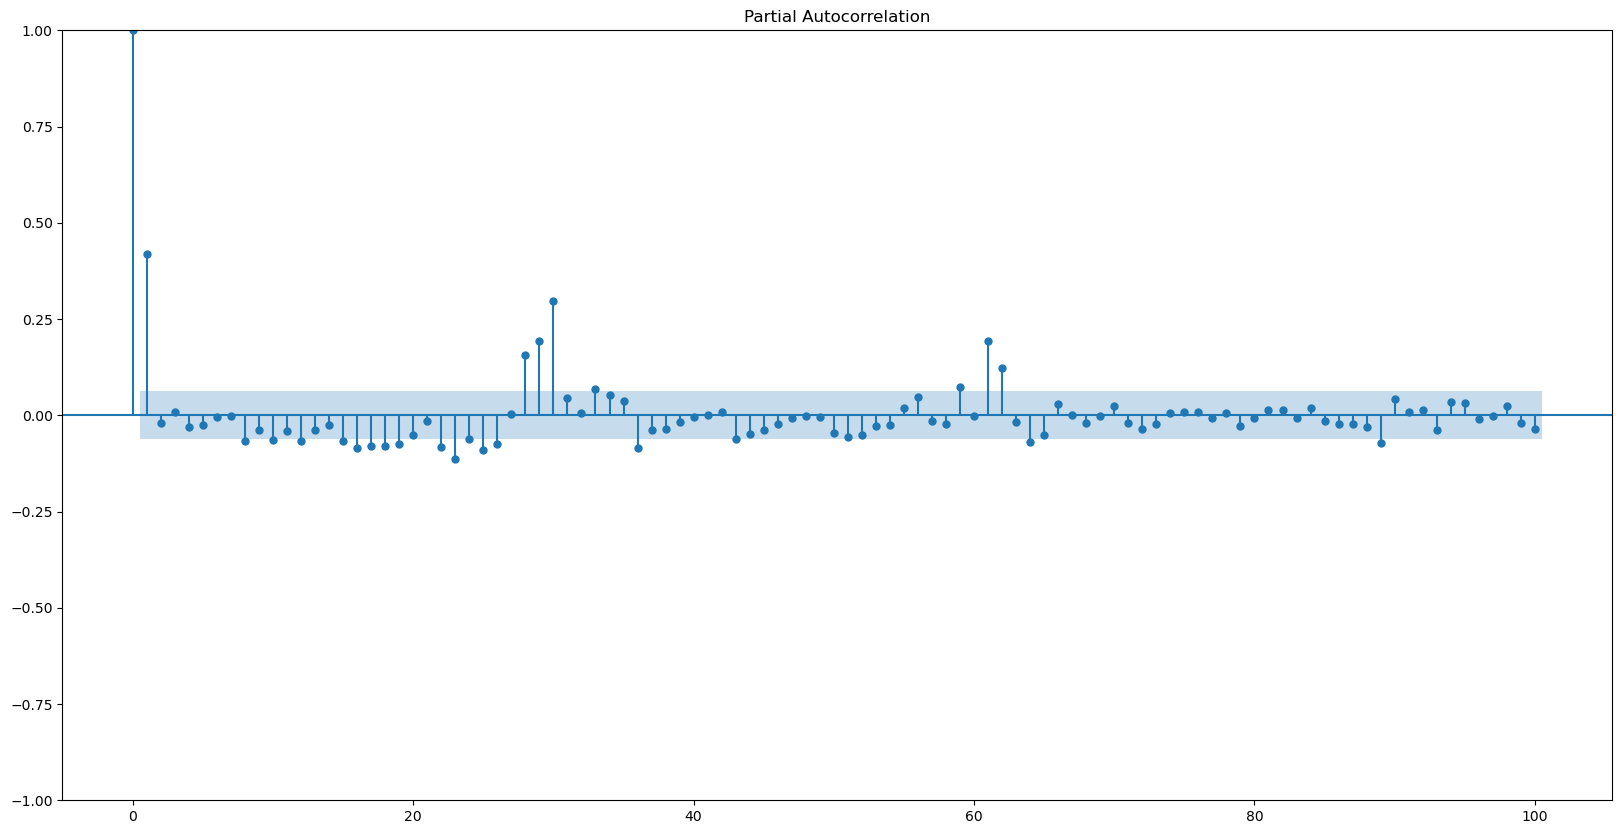

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_pacf(atm_df['target'], lags=100, ax=ax)
plt.show()

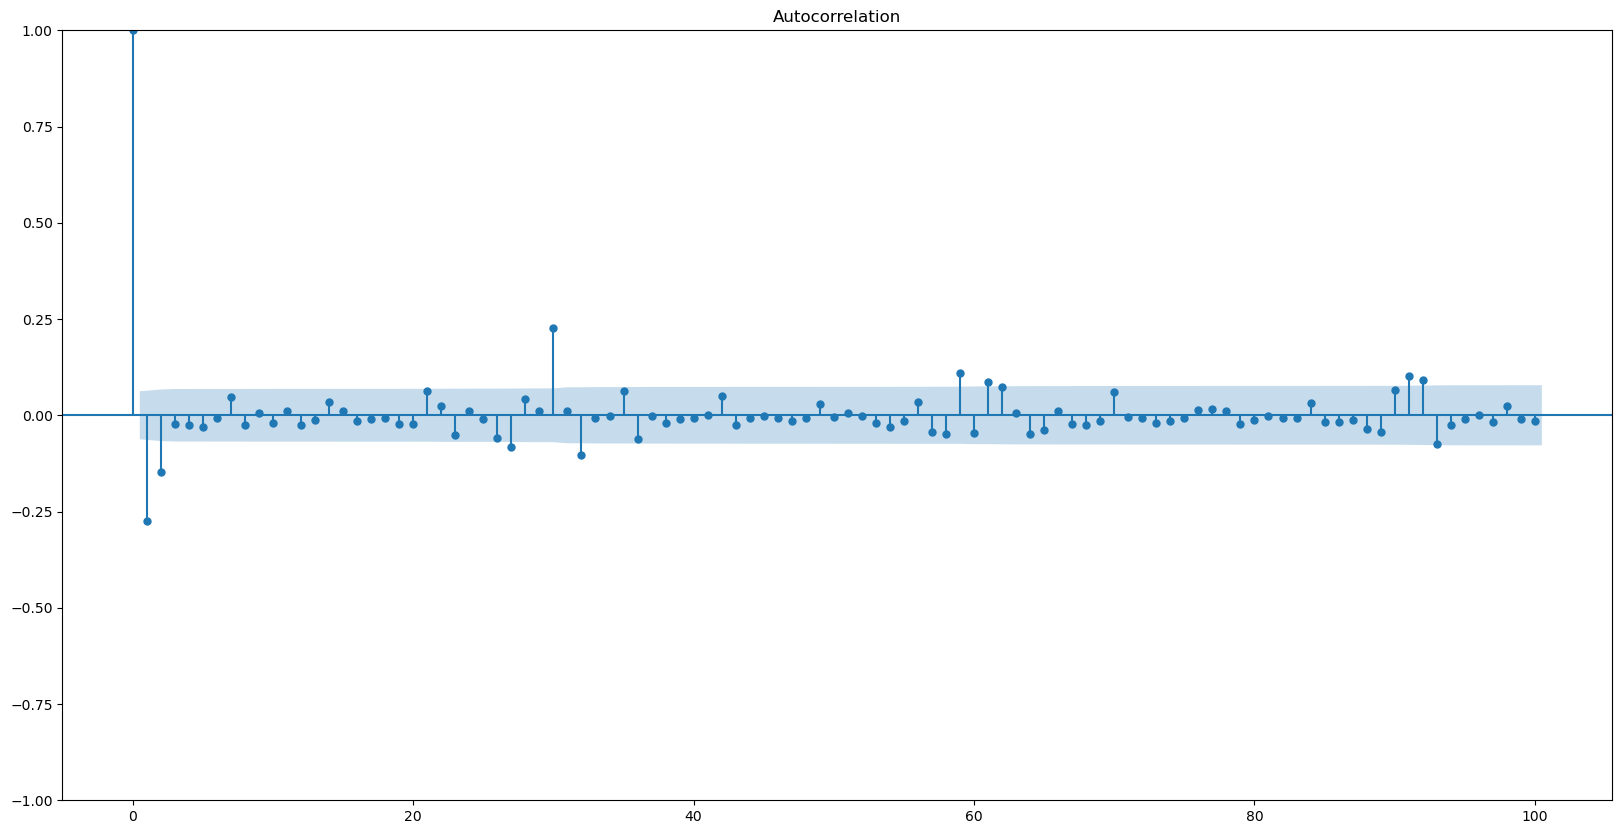

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_acf(atm_df['target'].diff().dropna(), lags=100, ax=ax)
plt.show()

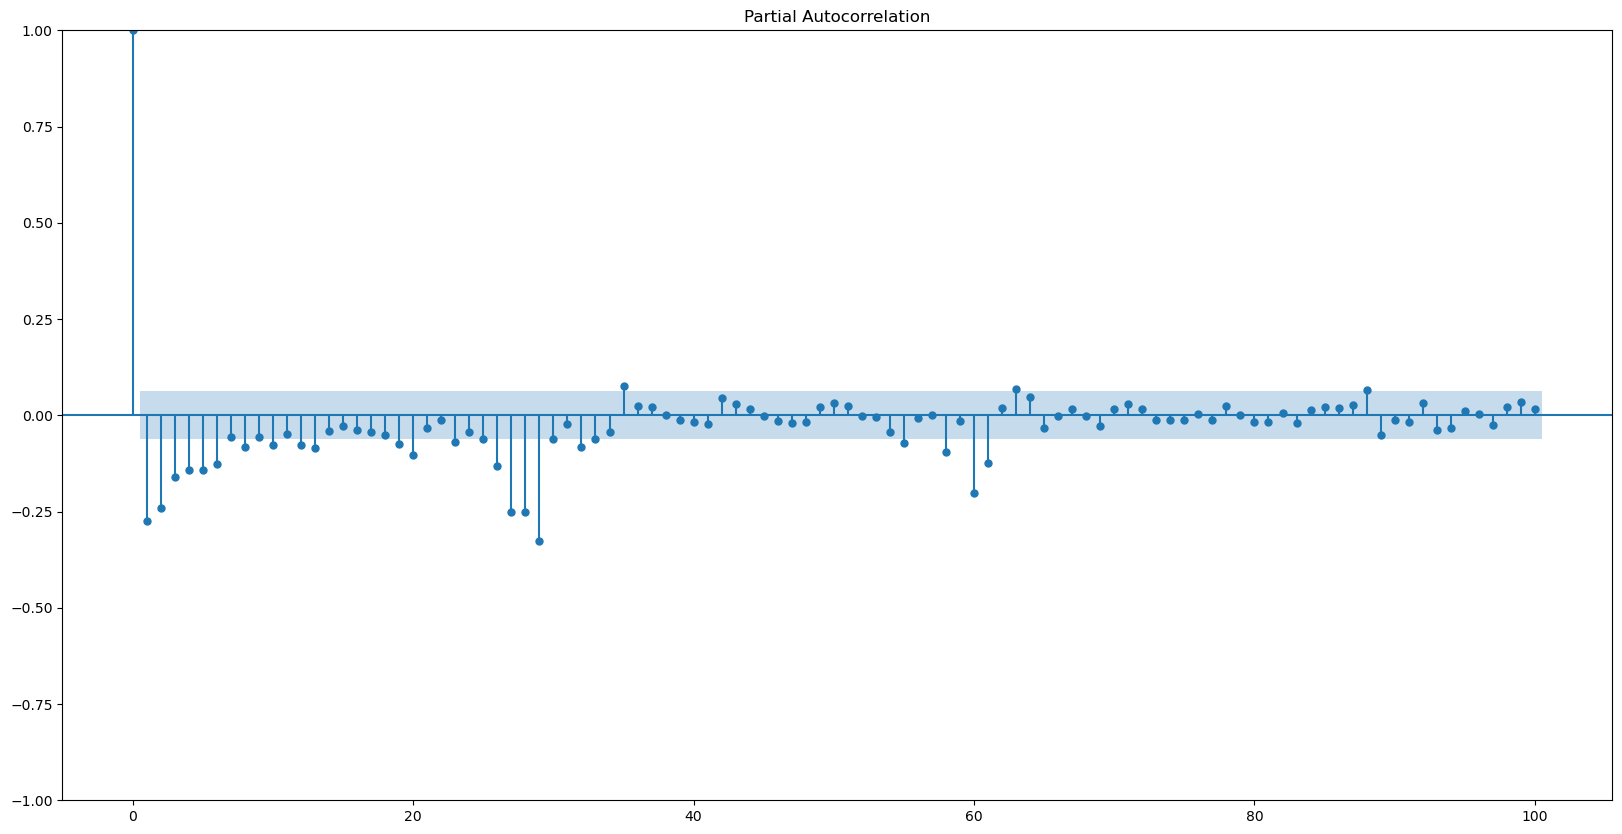

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_pacf(atm_df['target'].diff().dropna(), lags=100, ax=ax)
plt.show()

___
### Анализ данных

1. **Тренд**: В данных не наблюдается постоянных трендов на повышение или понижение, что указывает на константность математического ожидания ряда.

2. **Сезонность**: Построенные графики автокорреляции указывают на сильную месячную сезонность в данных.

3. **Цикличность**: Графики автокорреляции показывают, что корреляции наблюдаются не только по месяцам. На графике целевой переменной видны колебания вокруг среднего. Это говорит о наличии цикличности.

Указанные закономерности позволяют строить модели, учитывая месячную сезонность.
___

##### 2) Предобработка данных (0.5 балла)

Разбейте данные на трейн и тест. Размер теста: последние 50 дней.

Как легко заметить, данные неотрицательны. Но на случай использования мультипликативных моделей рекомендуется децентировать трейн в положительную полуось. Дополнительно можете произвести на трейне обратимые преобразования, которые сочтёте необходимыми (Box-Cox, детрендирование и т.п.).

In [8]:
atm_df.set_index('Date', inplace=True)

In [9]:
Y_train, Y_test = atm_df.iloc[:-50], atm_df.iloc[-50:]

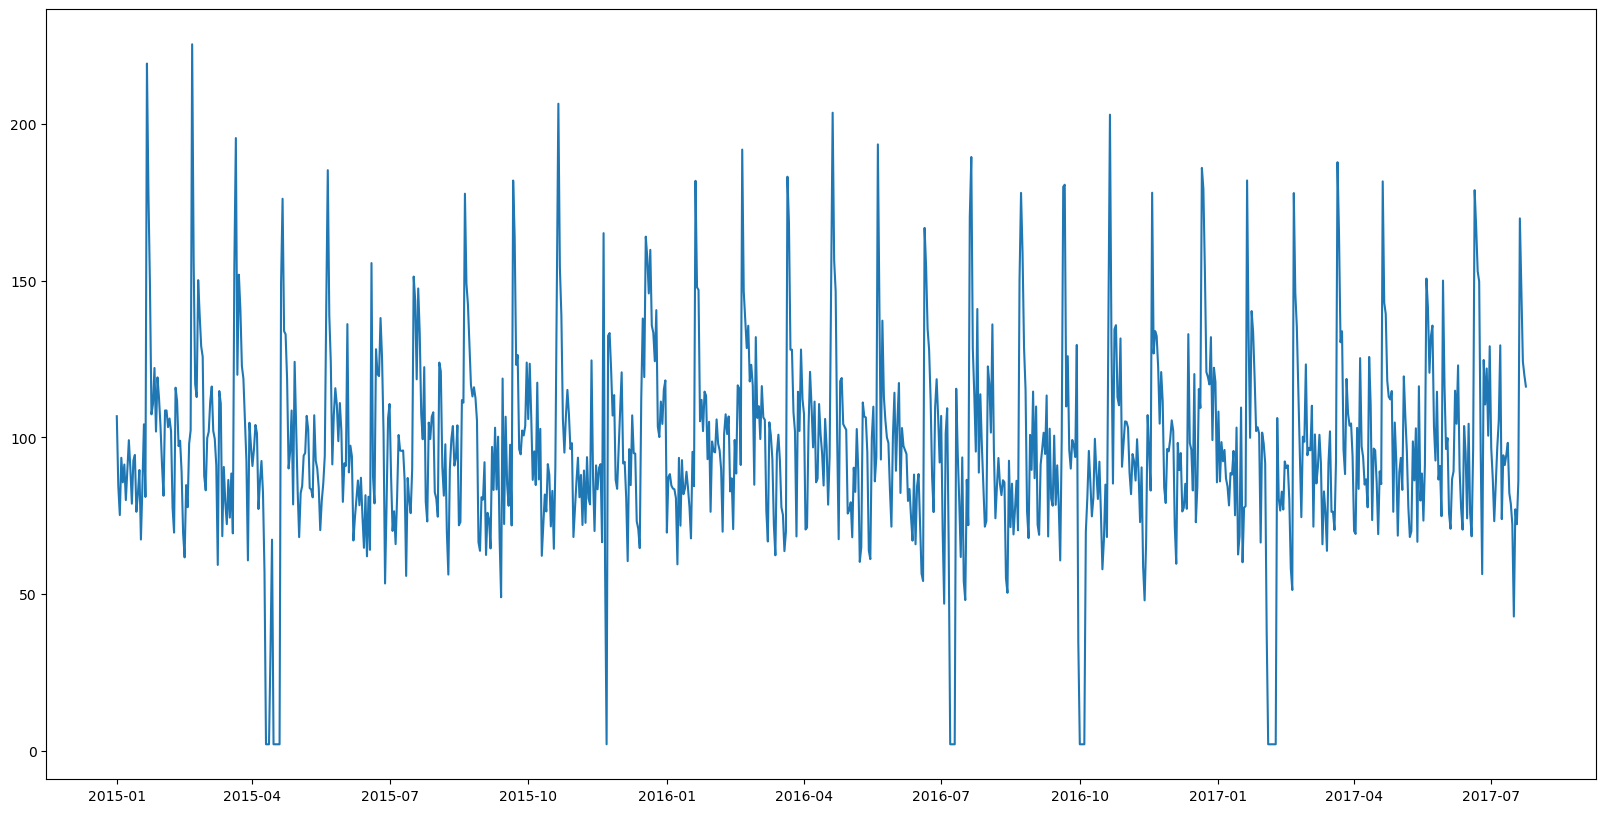

In [10]:
transformer = BoxCoxTransformer()
y_train_hat = transformer.fit_transform(Y_train + 5)

plt.figure(figsize=(20, 10))
plt.plot(y_train_hat)
plt.show()

### Блок 1. STL/MSTL


Здесь и далее будем работать только с трейном. В данном разделе мы попробуем декомпозировать ряд с помощью STL или MSTL. В этом случае наш ряд можно представить в следующем виде:

$$y^{train}_t = t_t + s_t + e_t$$

 $t_t$ - компонента трейна

 $s_t$ - компонента сезонности, в случае MSTL будет несколько компонент сезонности
 
 $e_t$ - компонента остатков


Для каждой компоненты мы будем оценивать отдельную многошаговую модель. Компоненты тренда и сезонности обычно простые по своей структуре. Для них мы будем использовать какие-нибудь тривиальные модели. Компонента остатков обычно самая сложная, так как включает в себя "всё остальное". Для неё мы будем строить модель с признаками аналогично ДЗ-1.

Каждую компоненту необходимо будет многошагово спрогнозировать на тестовый период. Так как STL-разложение аддитивно, прогнозы мы просто просуммируем.

$$\hat{y}^{test}_t = \hat{t}_t + \hat{s}_t + \hat{e}_t$$

Таким образом мы получим итоговый прогноз.


##### Разложение (0.3 балла)

Начнём с STL. Примените на трейне STL или MSTL-разложение (обоснуйте выбор). Обоснуйте период(ы), который вы берёте в качестве сезонного. Визуализируйте отдельные компоненты.

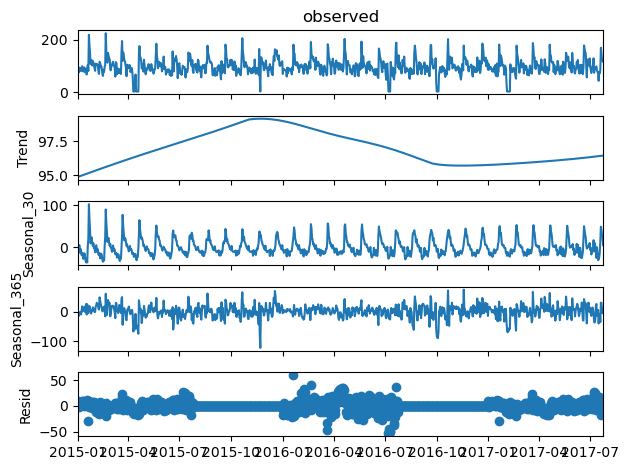

In [11]:
stl = MSTL(y_train_hat, periods=[30, 365])
res = stl.fit()
res.plot();

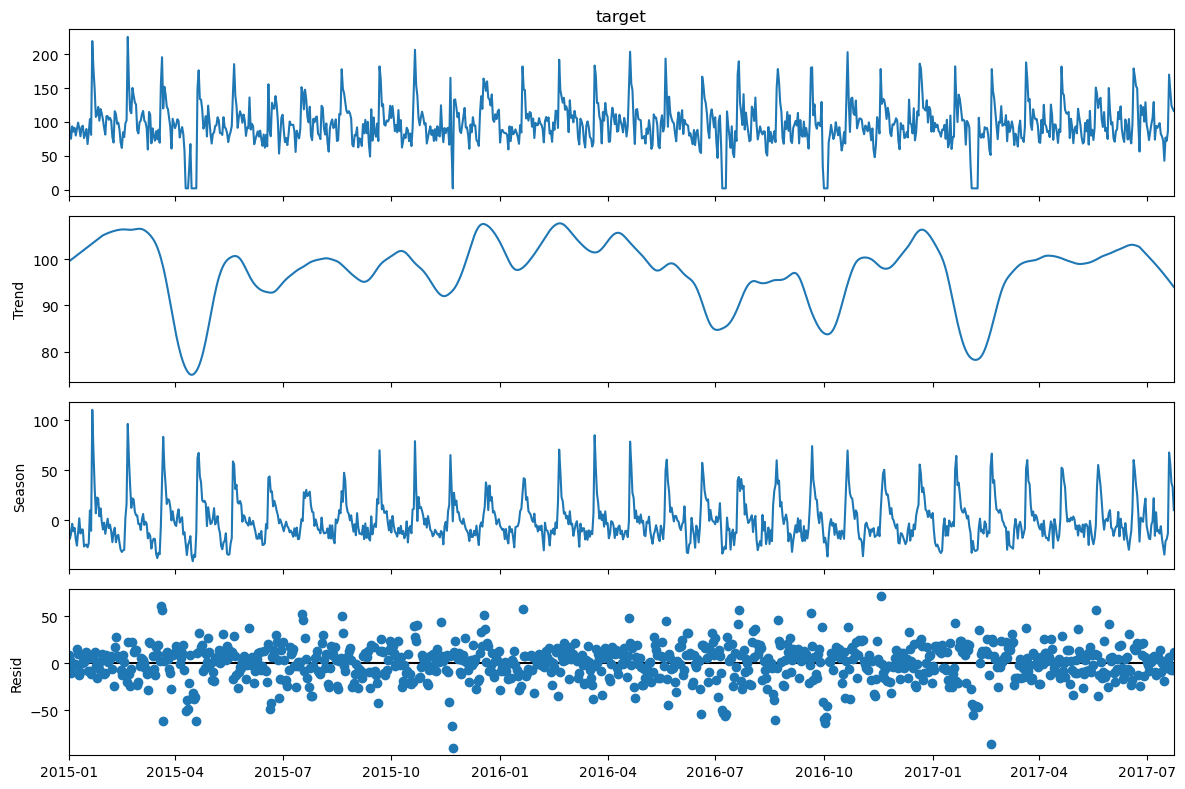

In [12]:
stl = STL(y_train_hat['target'], period=30)
res = stl.fit()

plt.rc("figure", figsize=(12, 8))  
res.plot()
plt.show()  


____
По графикам автокорреляции видно, что никакой другой сезонности, кроме месячной не наблюдается, поэтому разумно использовать STL.
___

##### Прогнозирование тренда (0.3 балла)

Достаньте из оценённой модели компоненту тренда. Спрогнозируйте этот ряд на длину теста любой простой моделью в зависимости от вида ряда (Наивная, RandomWalk, любой алгоритм сглаживания, ...).

In [13]:
trend = res.trend
model = SimpleExpSmoothing(trend)
model_fit = model.fit()
trend_pred = model_fit.forecast(50)

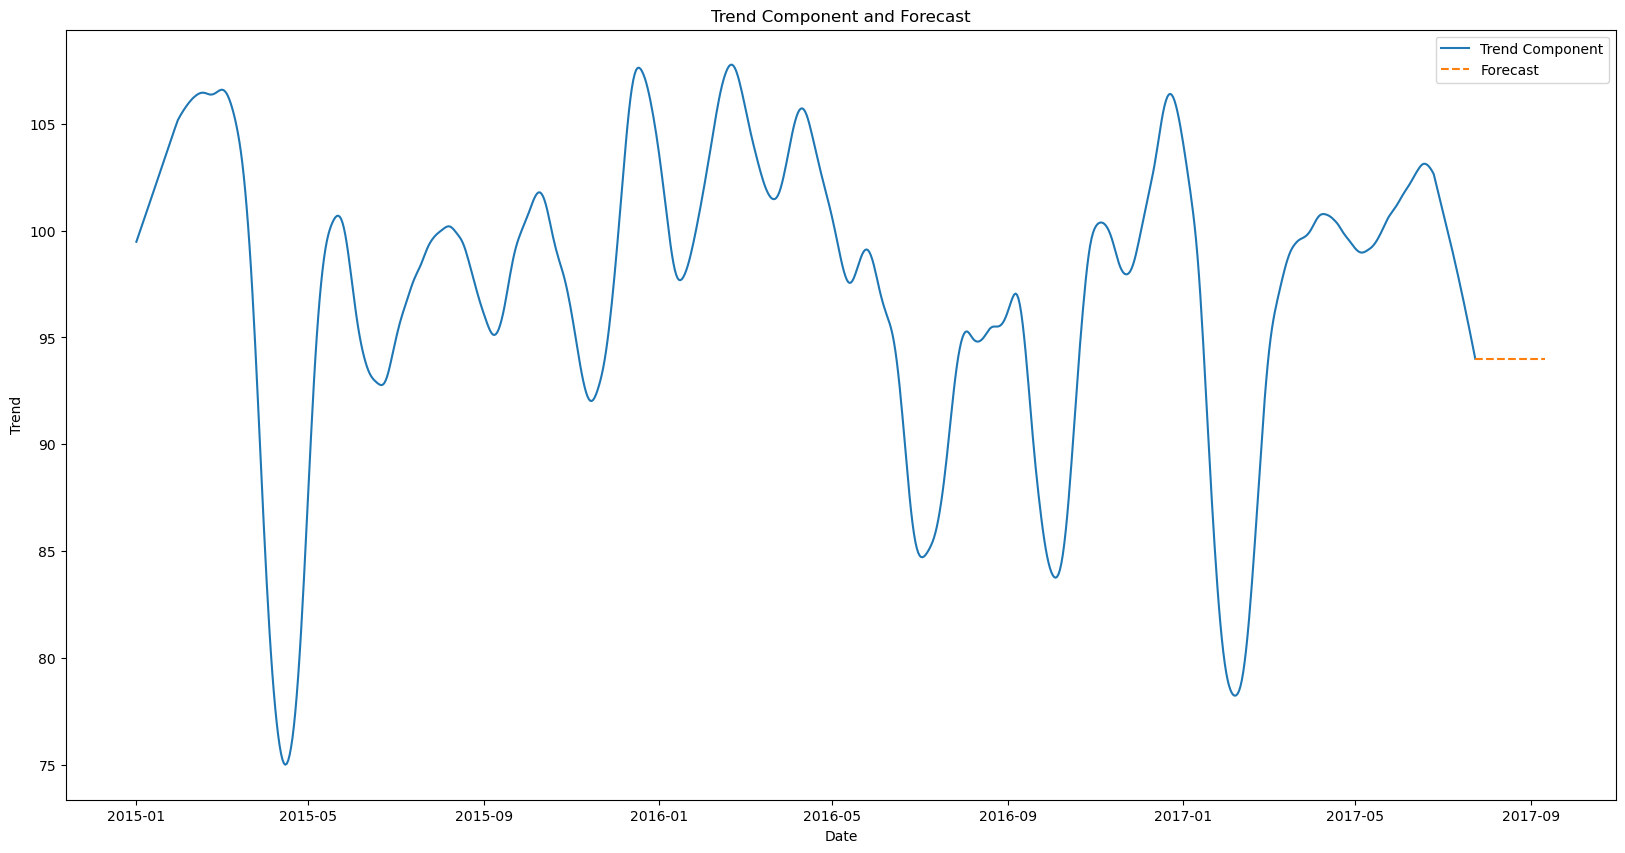

In [14]:
plt.figure(figsize=(20, 10))
plt.plot(trend.index, trend, label='Trend Component')
plt.plot(pd.date_range(trend.index[-1], periods=50, freq='D'), trend_pred, label='Forecast', linestyle='--')
plt.legend()
plt.title('Trend Component and Forecast')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.show()

##### Прогнозирование сезонности (0.3 балла)

Достаньте из модели компоненту или компоненты сезонности. Аналогично спрогнозируйте любой простой моделью без фичей.

In [15]:
seasonal = res.seasonal
pred_seasonal = seasonal[-60:]
pred_seasonal = pred_seasonal[:50]

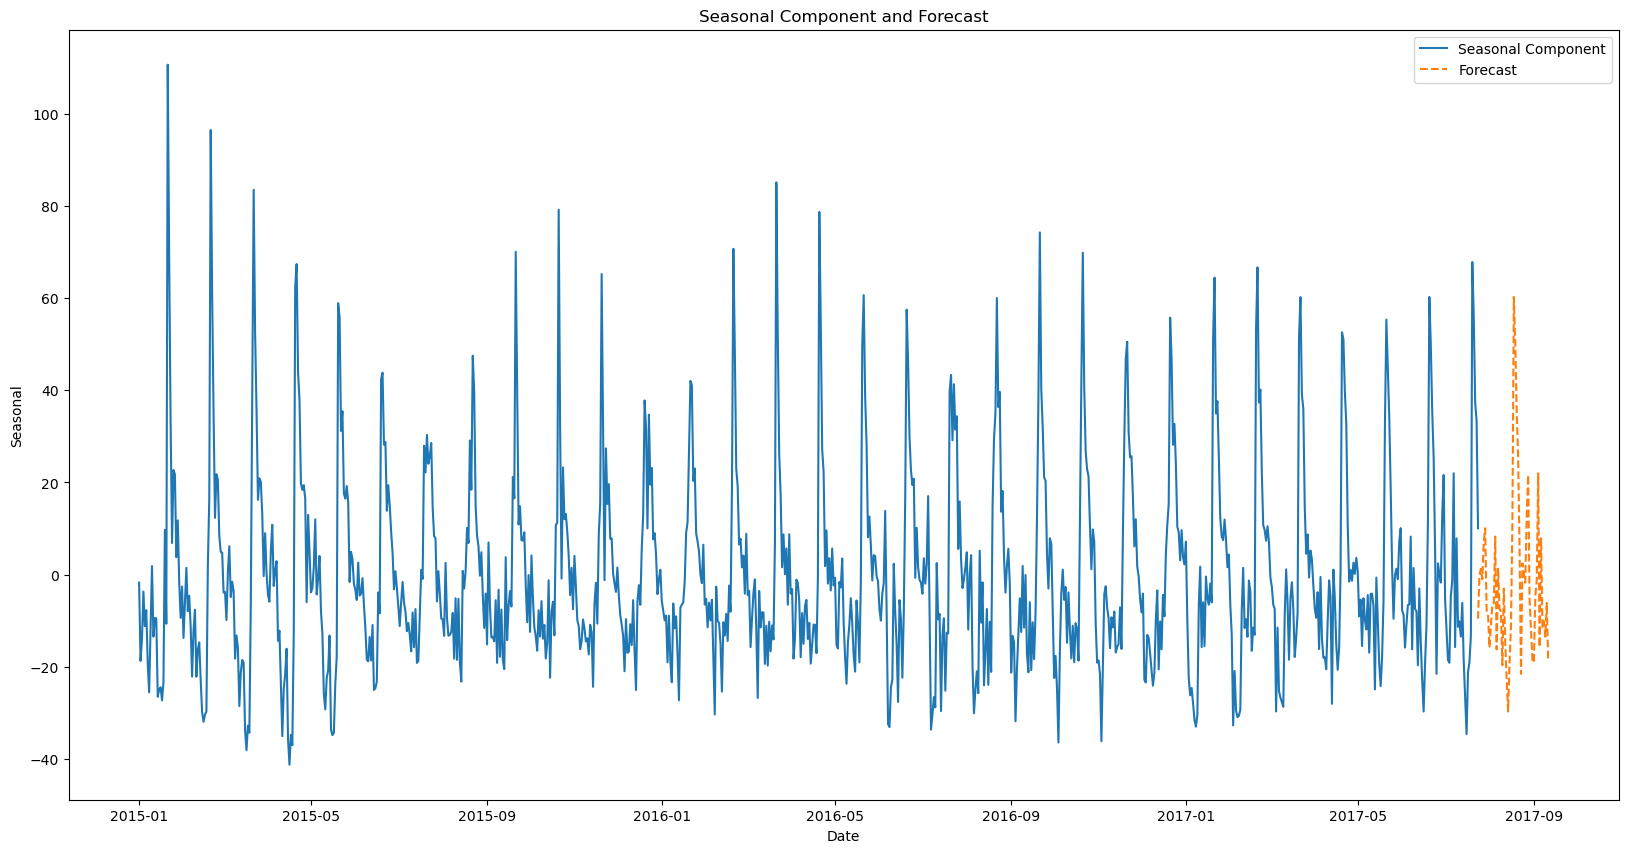

In [16]:
plt.figure(figsize=(20, 10))
plt.plot(seasonal.index, seasonal, label='Seasonal Component')
plt.plot(pd.date_range(seasonal.index[-1], periods=50, freq='D'), pred_seasonal, label='Forecast', linestyle='--')
plt.legend()
plt.title('Seasonal Component and Forecast')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.show()

#### Прогнозирование остатков. 

Теперь возьмёмся за самую сложную часть, прогнозирование компоненты остатков. Достаньте из модели эту компоненту.


In [17]:
residuals = res.resid


##### Подготовка данных (0.9 балла)

Многошаговый прогноз остатков потребует уже модели с фичами. По сути эта задача эквивалентна многошаговому прогнозированию из ДЗ-1. Стратегия многошагового прогнозирования и выбор модели также остаётся на ваше усмотрение. В текущем пункте вам необходимо подготовить фичи для модели. В этот раз вам не будет дано конкретных указаний по генерации переменных. Но будет выдана дополнительная информация о банкомате. Можете её использовать, можете нет, на ваше усмотрение. 

Расположение: ул Крымский Вал, 9стр45

Дополнительная информация: ГАУК культуры города Москвы ЦПКиО им. М.Горького

Широта: 55.73259

Долгота: 37.600891

Также в помощь прилагается файл с различными календарными фичами (events.csv), чтобы не повторять в этой домашке то же самое, что в прошлой. Можете использовать любые фичи из этого файла, но для засчитывания пункта необходимо придумать минимум три фичи (по 0.3 за каждую), не входящие в приложенный файл. Каждую используемую фичу (не важно, из файла или придуманную вами) необходимо кратко обосновать. Не забывайте учитывать потенциальные утечки. За их наличие балл также может быть снижен.

Результатом пункта должны быть вектор e_train и матрица e_X_train для модели остатков.

In [18]:
e_X_train = pd.read_csv('events.csv')
e_X_train.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
e_X_train['Date'] = pd.to_datetime(e_X_train['Date'])
#день месяца, ключевая ставка, изменение курса доллара

____
Первый признак, который я решил добавить - это день месяца. Логика тут такая, что, вероятно, снимают деньги наиболее часто в тот день, когда люди получают зарплату. Согласно законодательству, это должно проивходить не позднее 15-ого дня месяца и последнего дня месяца. Эти представления очень расплывчатые и конкретно к ним трудно подобрать какой-то признак, так как каждая компания в праве самостоятельно определять день выплаты заработной платы. Тем не менее, вероятнее всего, будут прослеживаться какие-то тенденции в этом вопросе. Чтобы вручную не отбирать дни, когда большая часть компаний или бюджетных учреждений может выдавать ЗП, я сделал новый признак. Так как я его закодировал с помощью OHE, модель сама определит, какие дни могут бять наиболее значимыми в этом вопросе.
___ 

In [19]:
e_X_train['day_of_month'] = e_X_train['Date'].dt.day

encoder = OneHotEncoder()

encoded_features = encoder.fit_transform(e_X_train[['day_of_month']]).toarray()

encoded_df = pd.DataFrame(encoded_features, 
                          columns=['day_{}'.format(int(i)) for i in range(1, encoded_features.shape[1]+1)])

e_X_train = e_X_train.join(encoded_df)



___
Второй признак, который я добавил - это ставка центрального банка. Вероятнее всего, люди будут больше снимать денег тогда, когда ставка достаточно маленькая. Вероятно, тут тоже прослеживается некоторая взимосвзяь, так как ставка напрямую влияет на лкивидность
___

In [20]:
cb_rate = pd.read_excel('cb_rate.xlsx')
e_X_train = pd.merge(e_X_train, cb_rate, how='left', left_on='Date', right_on='Дата')

In [21]:
e_X_train['rate'] = e_X_train['rate'].fillna(method='ffill').fillna(method='bfill')

___
Последний признак, который я посчитал значимым - это прирост курса валюты за день. Изменения курса валют отражает изменения в экономике. В соучае если курс значительно слабеет, например, люди склонны в панике снимать свои деньги. Так, отражая нестабильность в экономике, изменение курса может отражать также и изменение ликвидности.
___

In [22]:
e_X_train = e_X_train[(e_X_train['Date'] >= '2014-12-31') & (e_X_train['Date'] <= '2017-09-13')]
exchange_rate = pd.read_csv('exchange_rate.csv')
exchange_rate['Date'] = pd.to_datetime(exchange_rate['Date'])
exchange_rate['Close'] = exchange_rate['Close'].fillna(method='ffill').fillna(method='bfill')

In [23]:
e_X_train = pd.merge(e_X_train, exchange_rate[['Date', 'Close']], how='left', left_on='Date', right_on='Date')

In [24]:
e_X_train.columns
e_X_train.drop(['Дата'], axis=1, inplace=True)

In [25]:
e_X_train['Close'] = e_X_train['Close'].fillna(method='ffill').fillna(method='bfill')
e_X_train['Close'] = e_X_train['Close'].diff()

In [26]:
e_X_train['rate'] = e_X_train['rate'].shift(1)
e_X_train['Close'] = e_X_train['Close'].shift(1)
e_X_train['Close'].fillna(0, inplace=True)
e_X_train = e_X_train[(e_X_train['Date'] >= '2015-01-01') & (e_X_train['Date'] <= '2017-09-13')]

In [27]:
e_X_train.isna().sum()

Date                            0
выходной                        0
праздник                        0
короткий рабочий день           0
предпраздничный рабочий день    0
                               ..
day_29                          0
day_30                          0
day_31                          0
rate                            0
Close                           0
Length: 66, dtype: int64

____
Из несделанного: хотелось еще добавить 

#### Кросс-валидация

Теперь займёмся подбором оптимальной модели остатков. Для этого используем кросс-валидацию.

##### Реализация метода (0.6 балла)

Реализуйте метод скользящего окна. Реализуйте класс, который будет по входным параметрам окна выдавать индексы всех фолдов. По поведению можно ориентироваться на знакомый вам k-fold. Хорошей практикой будет возвращать в методе split генератор, хотя это и не обязательно. На каждом фолде модель будет обучаться на трейне и делать многошаговый прогноз на тест. 

Позаботьтесь о том, чтобы ширина окна была соотнесена в логичной пропорции с горизонтом прогнозирования. Длина трейна 55 при горизонте 50 -- сомнительная практика.


In [28]:
e_y_train = residuals

In [29]:
e_X_full = e_X_train.copy()
e_X_train = e_X_train[e_X_train['Date'] <= '2017-07-24']
e_X_full.set_index('Date', inplace=True)
e_X_train.set_index('Date', inplace=True)

In [30]:
import pandas as pd
import numpy as np

class CustomCrossVal:
    def __init__(self, window_size: int, step: int):
        """
        Args:
            window_size (int): The size of the training window.
            step (int): The number of observations to move forward in the series.
        """
        self.window_size = window_size
        self.step = step

    def split(self, X: pd.DataFrame):
        """
        Args:
            X (pandas DataFrame): DataFrame to split.
        Yields:
            The generator yields the indices for the train and test sets.
        """
        start = 0
        
        while start + self.window_size + self.step <= len(X):
            train_indices = np.arange(start, start + self.window_size)
            test_indices = np.arange(start + self.window_size, start + self.window_size + self.step)
            
            yield train_indices, test_indices
            
            start += self.step


##### Отбор моделей (0.5 балла)

Выберите несколько моделей-кандидатов исходя из свойств ряда (обоснуйте) и отберите с помощью реализованной вами кросс-валидации наилучшую. Можно использовать разные модели либо разные наборы фичей. Метрика: MAE.

___
Так как данных у нас очень много, то предпочтительной стратегией будет прямая стратегия.
___

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

def dir(model, X_train, X_test, y_train, period=50):
    start = len(y_train)
    preds_dir = []
    for i in range(period):
        model.fit(X_train.iloc[:start-i], y_train.iloc[i:])
        pred = model.predict(X_test.iloc[[0]])
        preds_dir.append(float(pred))
    return preds_dir

def evaluate_dir(models, X, y, window_size, step, period):
    cv = CustomCrossVal(window_size, step)
    results = {}
    for model_name, model in models.items():
        errors = []
        for train_idx, test_idx in cv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train = y.iloc[train_idx]
            preds = dir(model, X_train, X_test, y_train, period=period)
            true_values = y.iloc[test_idx].values[:len(preds)]
            error = mean_absolute_error(true_values, preds)
            errors.append(error)
        results[model_name] = np.mean(errors)
    return results

models = {
    "LinearRegression": LinearRegression(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "RandomForestRegressor": RandomForestRegressor()
}

results = evaluate_dir(models, e_X_train, e_y_train, 400, 50, 50)


In [32]:
results

{'LinearRegression': 15.962907329933206,
 'GradientBoostingRegressor': 14.512447197001908,
 'RandomForestRegressor': 14.01312421738226}

In [33]:
def evaluate_params(X, y, window_size, step, period, param_grid):
    cv = CustomCrossVal(window_size, step)
    best_score = float('inf')
    best_params = None
    
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            errors = []
            for train_idx, test_idx in cv.split(X):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train = y.iloc[train_idx]
                
                model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
                preds = dir(model, X_train, X_test, y_train, period=period)
                true_values = y.iloc[test_idx].values[:len(preds)]
                error = mean_absolute_error(true_values, preds)
                errors.append(error)
            
            mean_error = np.mean(errors)
            if mean_error < best_score:
                best_score = mean_error
                best_params = {'n_estimators': n_estimators, 'max_depth': max_depth}
                
    return best_params, best_score

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 15]
}

best_params, best_score = evaluate_params(e_X_train, e_y_train, 400, 50, 50, param_grid)

In [34]:
best_params, best_score

({'n_estimators': 50, 'max_depth': 5}, 13.200496245517039)

##### Прогноз моделей (0.5 балла)

Обучите наилучшую модель остатков на всём трейне и постройте прогноз на тестовый период, используя выбранную вами многошаговую стратегию.

In [35]:
e_X_test = e_X_full[e_X_full.index > '2017-07-24']
e_X_test = e_X_test[e_X_test.index <= '2017-09-12']
e_preds = dir(RandomForestRegressor(n_estimators=50, max_depth=5), e_X_train, e_X_test, e_y_train, 50)

In [36]:
len(e_preds), len(trend_pred), len(pred_seasonal)

(50, 50, 50)

##### Результаты и визуализация (0.6 балла)

Соберите в сумму прогнозы всех компонент STL-разложения на тесте. Не забудьте на сумму прогнозов компонент применить преобразования, обратные тем, которые были сделаны на трейне.  Визуализируйте прогноз и тестовые данные. Подсчитайте MAE прогноза.

In [37]:
y_pred = np.array(e_preds) + np.array(trend_pred) + np.array(pred_seasonal)
y_pred

array([ 91.10889779,  99.82766018, 102.61207758,  99.02619335,
        87.79242519,  83.52898799,  89.74918541,  92.92627409,
        83.21042764,  89.45140285,  93.71524834,  81.4193719 ,
        88.71312802,  79.25915942, 101.94686445,  92.56573968,
        91.12522256,  80.01544813,  80.66475167,  66.86398936,
        74.43466768,  69.92444261,  80.70079919,  88.40052844,
       111.59571355, 144.04156   , 120.53706707, 131.82918544,
       128.72005444, 106.53708421,  79.94603836, 103.75658627,
        81.21445346,  73.17355619, 108.37870138, 123.07106664,
        94.69593162,  86.64001625,  81.54062427,  66.34716485,
        75.98838601,  95.97148229, 124.83224584,  84.78830691,
       106.64901802,  89.26532868,  74.64736037,  67.43807316,
        92.51825787,  81.13920226])

In [38]:
def inverse_boxcox(y, lambda_value):
    """Применяет обратное преобразование Box-Cox.
    
    Args:
        y (array-like): Преобразованный временной ряд.
        lambda_value (float): Значение параметра lambda, использованного для преобразования Box-Cox.
        
    Returns:
        array-like: Исходный временной ряд.
    """
    if lambda_value == 0:
        return np.exp(y) - 5  
    else:
        return (y * lambda_value + 1) ** (1 / lambda_value) - 5

lambda_value = transformer.lambda_  

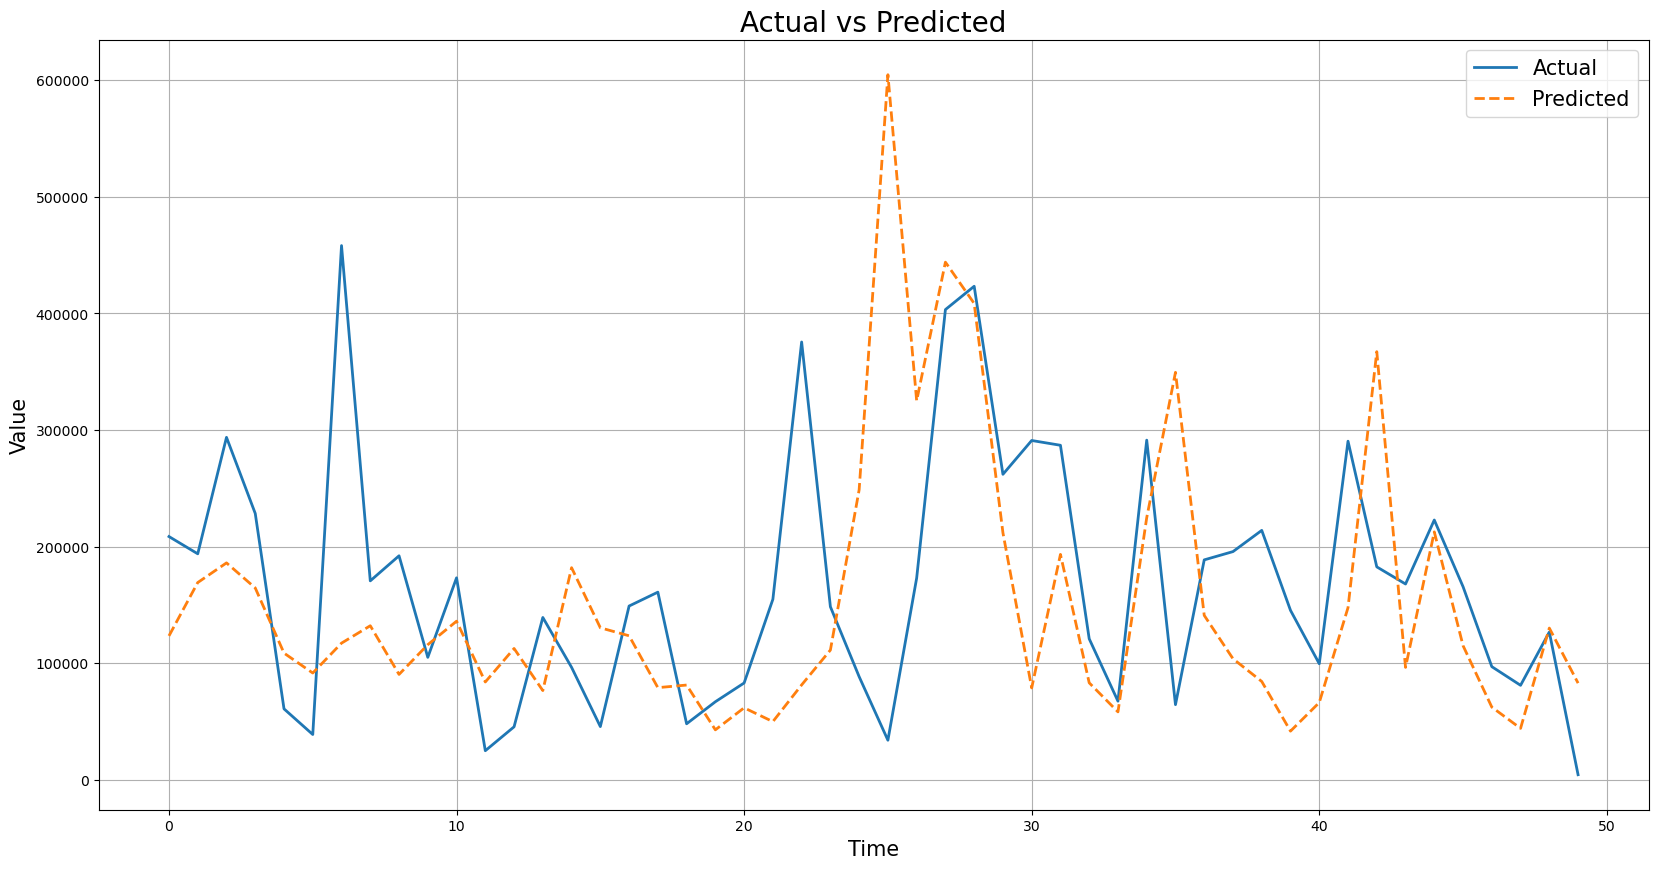

Mean Absolute Error (MAE): 92107.7334810733


In [39]:
y_pred_original = inverse_boxcox(y_pred, lambda_value)

mae = mean_absolute_error(Y_test, y_pred_original)

plt.figure(figsize=(20, 10))
plt.plot(Y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred_original, label='Predicted', linewidth=2, linestyle='--')
plt.title('Actual vs Predicted', fontsize=20)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

print(f"Mean Absolute Error (MAE): {mae}")

##### Бэктестинг (0.75 балла)

Попробуем протестировать in-sample итоговую модель, которая получилась. Для этого нам необходимо получить остатки суммарной модели на трейне. Для этого нам необходимо вернуться к моделям отдельных компонент и построить одношаговые прогнозы на всём участке train.

$$e^{clean}_t = y^{train}_t - (\hat{t}^{train}_t + \hat{s}^{train}_t + \hat{e}^{train}_t)$$

Нарисуйте графики автокорреляций этих остатков. Есть ли в каких-то интересных датах значимые пики? Как думаете, с чем эти ошибки модели связаны? (0.5 балла)

Проведите тест Ljung-Box. Протестируйте остатки на наличие серийных автокорреляций при нескольких m. Проинтерпретируйте результаты теста $\alpha = 0.05$. (0.25 балла)

Если нулевая гипотеза отвергается, можете попытаться улучшить модель и поискать фичи по графикам автокорреляций, но это опционально. В ряде ситуаций становится сложно построить модель, в которой гипотеза не отвергается, поэтому иногда на наличие автокорреляций закрывают глаза.

In [40]:
model_exp = SimpleExpSmoothing(trend)
model_fit = model_exp.fit()
trend_ev = np.array(model_fit.fittedvalues)

In [41]:
seas_ev = np.array( ( list(seasonal[-60:]) * (936 // len(seasonal[-60:]) + 1))[:936] )

In [42]:
model_RFR = RandomForestRegressor(n_estimators=50, max_depth=5)
model_RFR.fit(e_X_train, e_y_train)
e_ev = np.array(model_RFR.predict(e_X_train))

In [43]:
len(np.array(Y_train['target'])), len(e_ev), len(seas_ev), len(trend_ev)

(936, 936, 936, 936)

In [44]:
e_clean = np.array(Y_train['target']) - inverse_boxcox((trend_ev + seas_ev + e_ev), lambda_value)

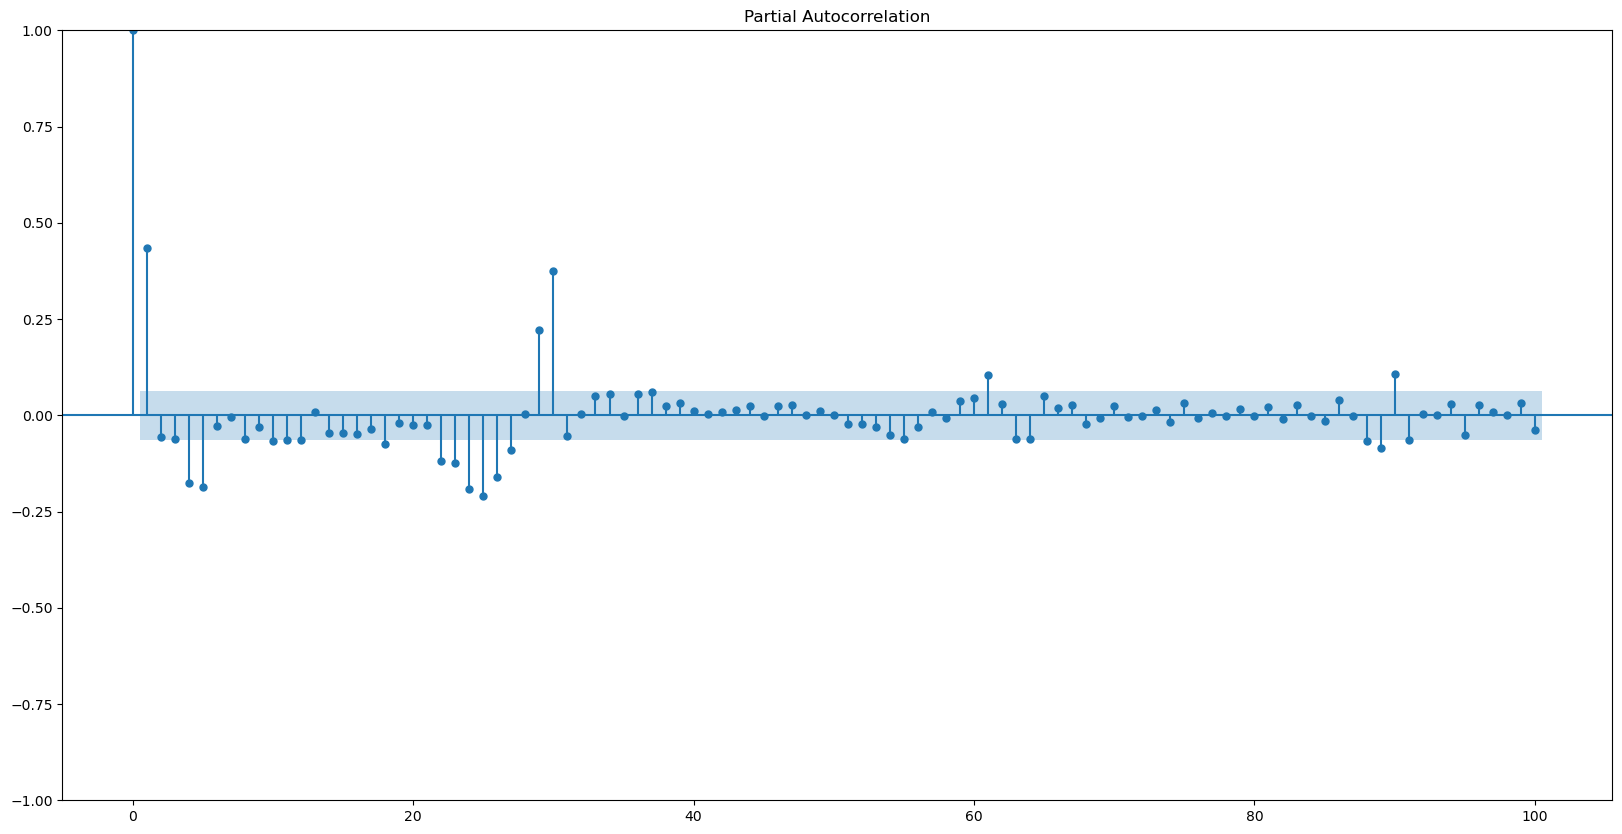

In [45]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_pacf(e_clean, lags=100, ax=ax)
plt.show()

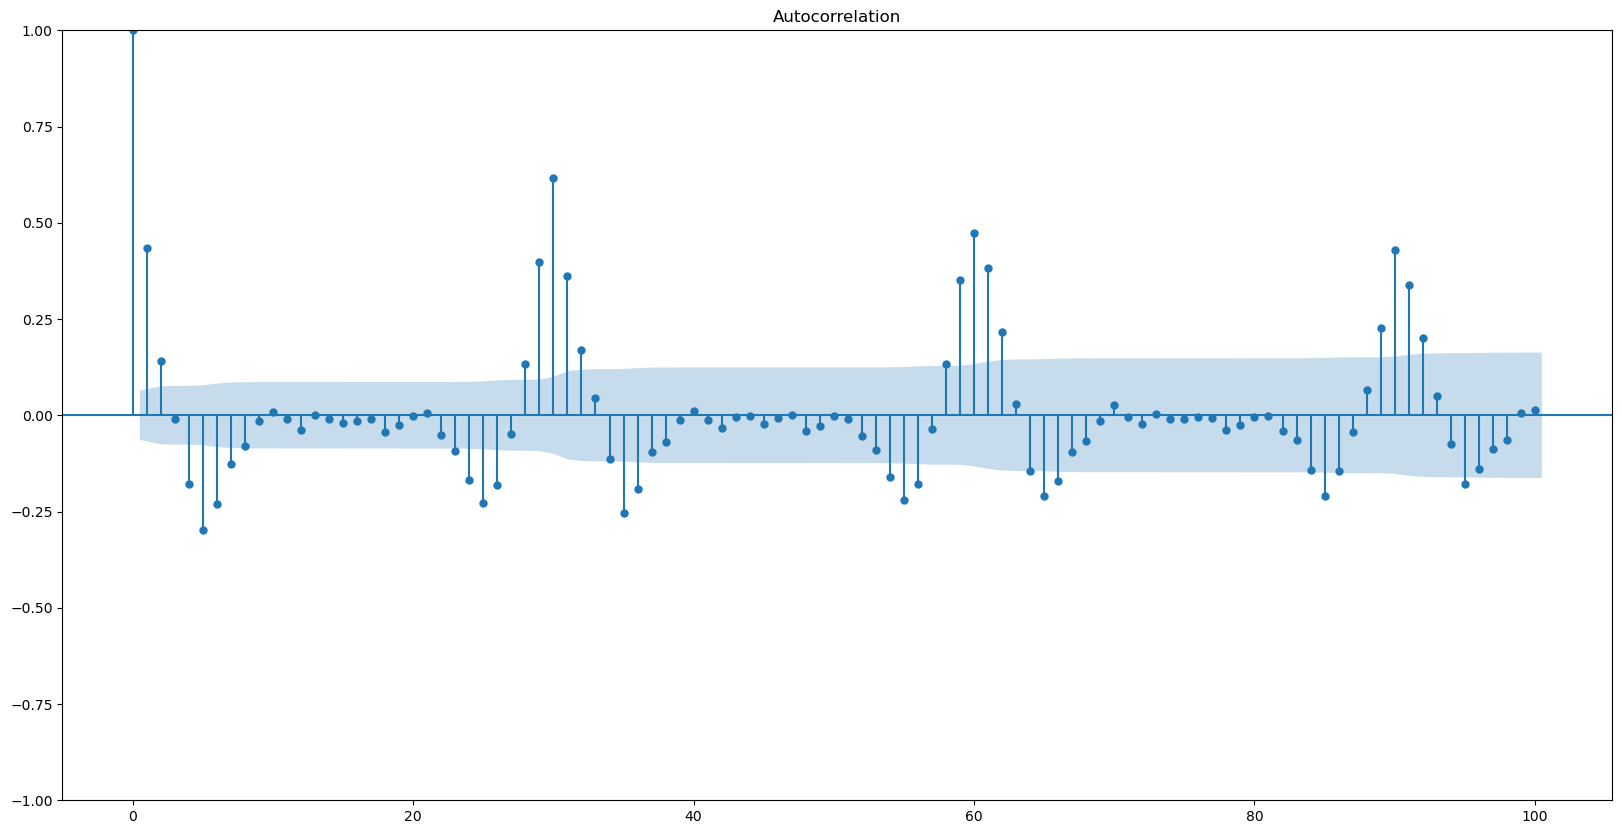

In [46]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_acf(e_clean, lags=100, ax=ax)
plt.show()

___
Можно снова заметить сильные автокорреляции по месяцам - 30, 60, 90 дней. Связано это с тем, что ноивная модель прогноза сезонности ориентируется каждый раз только на один месяц и поэтому систематически заставляет модель именного тогда, когда сезонность играет наибольшую роль. Также это может быть связано с тем, что модель не лучшим образом чистит сезонность, так как и график тренда получился совсем не гладким
___

In [47]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(e_clean, lags=[30, 60, 90], return_df=True)

print(lb_test)


        lb_stat      lb_pvalue
30  1044.251484  2.311506e-200
60  1813.392556   0.000000e+00
90  2465.501001   0.000000e+00


___
Результаты теста Ljung-Box показывают следующее:

- **Для 30 лагов**: p-значение значительно меньше 0.05. Это указывает на наличие автокорреляции в остатках на 30 лагах.
- **Для 60 лагов**: p-значение равно 0, что также значительно меньше 0.05, указывая на наличие автокорреляции в остатках на 60 лагах.
- **Для 90 лагов**: p-значение равно 0, что указывает на очень сильное наличие автокорреляции в остатках на 90 лагах.


### Блок 2. ETS-модель

Теперь повторим то же самое, только моделировать тренд и сезонность будем ETS-моделью, а на остатки ETS-модели навешивать вторую модель.

$$y^{train}_t = y^{ETS}_t + e^{ETS}_t$$


##### Визуальный анализ (1 балл)

Вернитесь к y_train. Взгляните на ряд и опишите, какие из вариантов ETS-модели подошли бы под наши данные. Сформируйте сетку параметров для моделей-кандидатов. Кратко поясните каждую опцию, которую вы включаете в сетку, основываясь на визуальном анализе.

___
Трудно сказать, есть ли в этом ряду тренд. По графику кажется, что нет, но чтобы понять точно рассмотрим модель с обоими вариантами. Сезонность в данных однозначно есть. Ошибка скорее аддитивная, так как уровень ряда почти не меняется, но для точности также рассмотрим варианты

##### Кросс-валидация (0.3 балла)

С помощью кросс-валидации выберите наилучшую по MAE ETS-модель. Обучите её на всём трейне и спрогнозируйте на тест. 

In [48]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

def evaluate_auto_ets(y, cv, param_grid):
    best_score = float('inf')
    best_params = None
    
    for error in param_grid['error']:
        for trend in param_grid['trend']:
            for seasonal in param_grid['seasonal']:
                for seasonal_periods in param_grid['seasonal_periods']:
                    scores = []
                    for train_indices, test_indices in cv.split(y):
                        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

                        

                        damped_trend = trend is not None
                        
                        model = ETSModel(y_train, error=error, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods, damped_trend=damped_trend)
                        model_fit = model.fit()
                        predictions = model_fit.forecast(len(y_test))
                        score = mean_absolute_error(y_test, predictions)
                        scores.append(score)
                    
                    mean_score = np.mean(scores)
                    print(mean_score)
                    if mean_score < best_score:
                        print('Update')
                        best_score = mean_score
                        best_params = {
                            'error': error,
                            'trend': trend,
                            'seasonal': seasonal,
                            'seasonal_periods': seasonal_periods
                        }
    
    best_model = ETSModel(y, error=best_params['error'], trend=best_params['trend'], seasonal=best_params['seasonal'], seasonal_periods=best_params['seasonal_periods'], damped_trend=best_params['trend'] is not None).fit()
    
    return best_params, best_model, best_score

param_grid = {
    'error': ['add', 'mul'],
    'trend': ['add', None],
    'seasonal': ['add', 'mul'],
    'seasonal_periods': [30]
}

cv = CustomCrossVal(window_size=400, step=50)
best_params, best_model, best_score = evaluate_auto_ets(y_train_hat['target'], cv, param_grid)

predictions = best_model.forecast(50)



26.278948231276775
Update
25.63032271684067
Update
26.096185466587706
25.66986287838315
33.60482107361556
24.837927629206643
Update
24.60383275349299
Update
24.867995879627998


In [49]:
best_params, best_score

({'error': 'mul', 'trend': None, 'seasonal': 'add', 'seasonal_periods': 30},
 24.60383275349299)

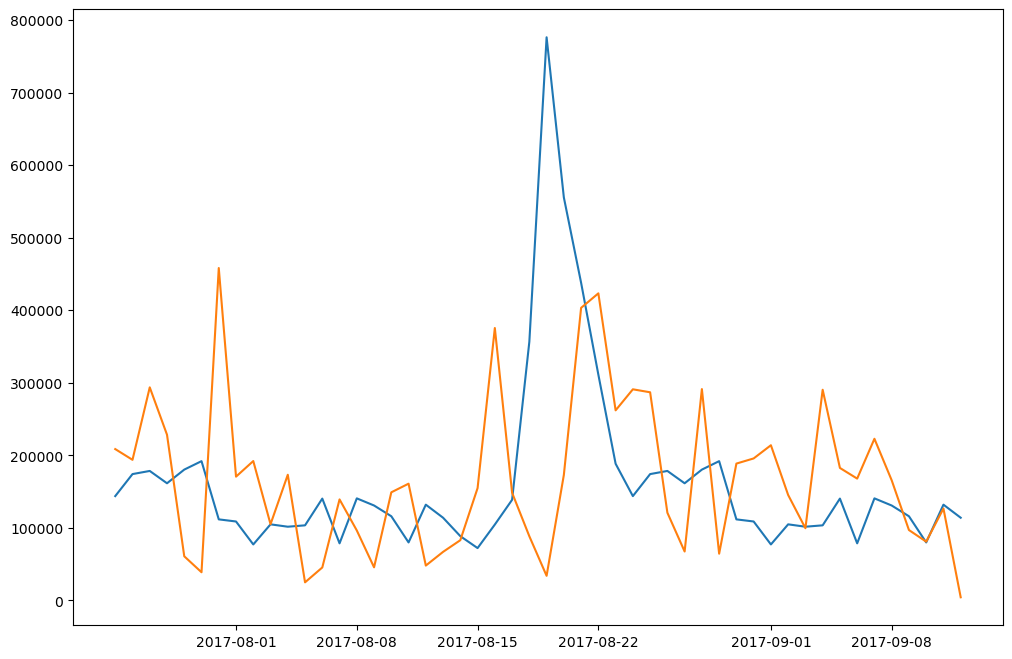

In [50]:
plt.plot(inverse_boxcox(predictions, lambda_value))
plt.plot(Y_test)

##### Подготовка данных (0.1 балла)

Достаньте остатки ETS-модели на трейне.
            $$e_{ETS} = y_{train} - \hat{y}_{train}$$

Это можно сделать с помощью метода predict_residuals. Построим на временном полученном временном ряде многошаговую модель. Можно использовать те же фичи, что и в разделе про STL, без дополнительных пояснений. Если вводите новые фичи, коротко поясните каждую. Результатом пункта должны быть вектор e_train и матрица e_X_train для модели остатков.

In [51]:
fitted_values = best_model.fittedvalues
e_train = y_train_hat['target'] - fitted_values

##### Отбор моделей и кросс-валидация (0.5 баллов)

Отберите несколько моделей-кандидатов для прогнозирования остатков и отберите на кросс-валидации наилучшую по MAE модель. Размер валидации на каждом фолде всё также равен длине тестовой выборки. Используйте реализованный ранее класс для кросс-валидации. 

In [52]:
results = evaluate_dir(models, e_X_train, e_train, 400, 50, 50)

In [53]:
results

{'LinearRegression': 24.69908108222768,
 'GradientBoostingRegressor': 20.591247533782614,
 'RandomForestRegressor': 20.343509922628254}

In [54]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 15]
}
best_params, best_score = evaluate_params(e_X_train, e_train, 400, 50, 50, param_grid)

In [55]:
best_params, best_score

({'n_estimators': 100, 'max_depth': 5}, 19.56459748433956)

##### Прогноз остатков ETS (0.5 баллов)
Обучите наилучшую модель на всём наборе остатков трейна. Постройте прогноз на тест с помощью любой многошаговой стратегии.

Суммируйте прогнозы двух компонент в итоговый прогноз. Не забудьте в конце наложить обратные преобразования ряда, если вы их делали в самом начале.

$$\hat{y}^{test}_t = \hat{y}^{ETS}_t + \hat{e}^{ETS}_t$$

Подсчитайте MAE.


In [56]:
e_preds = dir(RandomForestRegressor(n_estimators=100, max_depth=5), e_X_train, e_X_test, e_train, 50)

In [57]:
y_val = inverse_boxcox((predictions + e_preds), lambda_value)

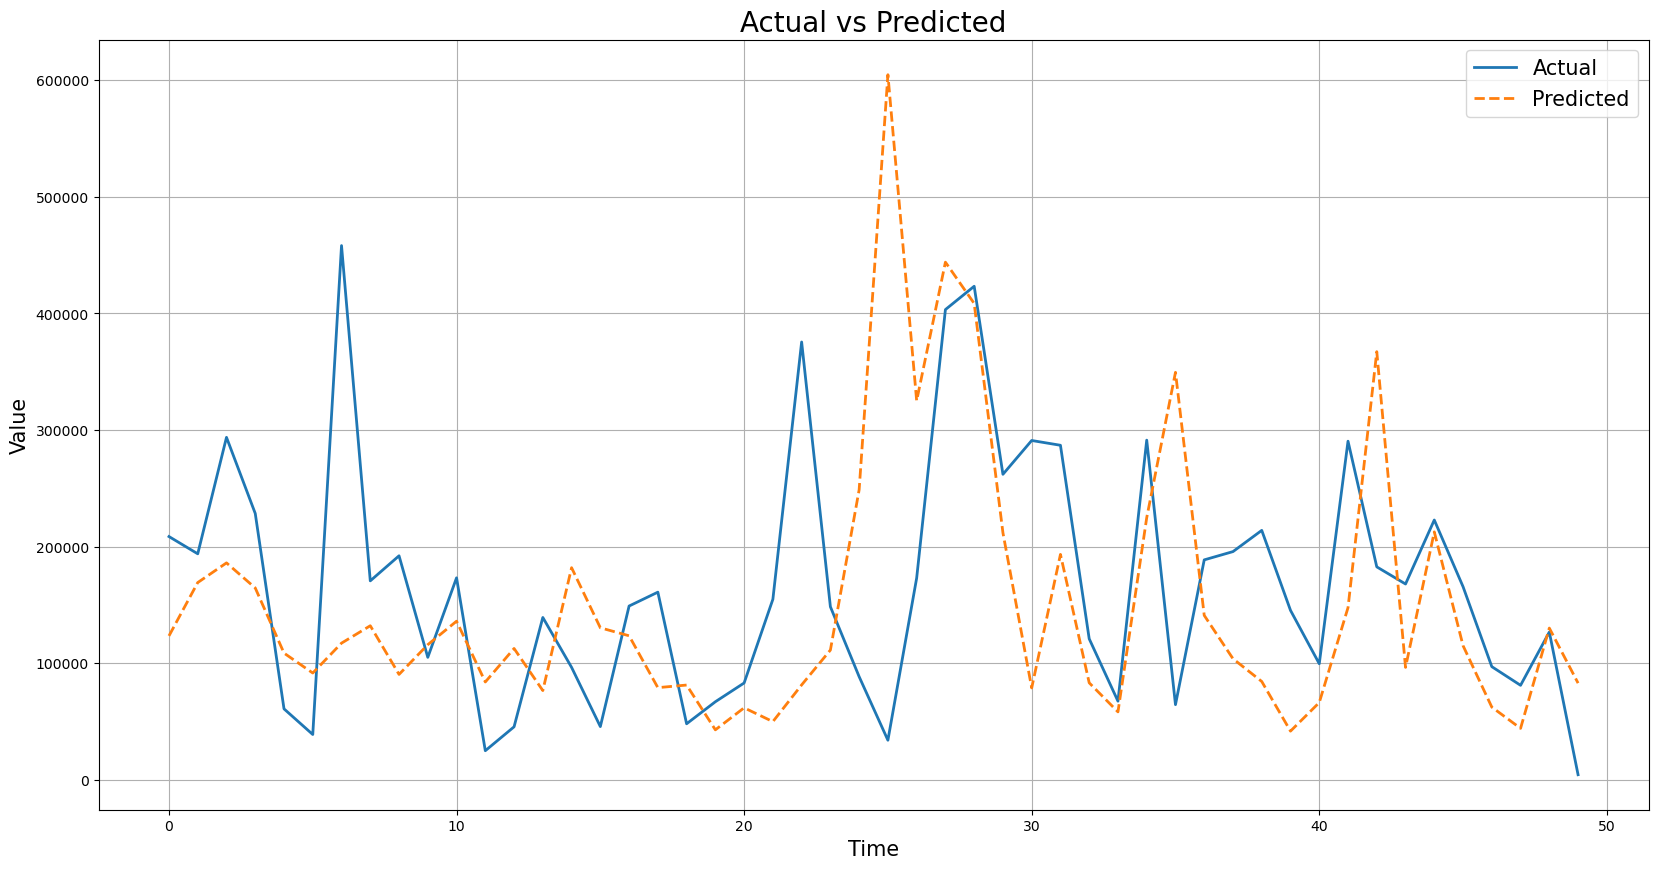

Mean Absolute Error (MAE): 81917.83570439051


In [58]:
mae = mean_absolute_error(Y_test, y_val)

plt.figure(figsize=(20, 10))
plt.plot(Y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred_original, label='Predicted', linewidth=2, linestyle='--')
plt.title('Actual vs Predicted', fontsize=20)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

print(f"Mean Absolute Error (MAE): {mae}")

##### Бэктестинг (0.5 балла)

Найдите остатки одношаговых моделей на тренировочной выборке.

$$e^{cleaned}_t = y^{train}_t - (\hat{y}^{ETS}_t + \hat{e}^{ETS}_t) $$

Так как получить одношаговые прогнозы $\hat{y}^{ETS}_t$ класс из Sktime почему-то не позволяет. Но мы помним, что 

 $$e_{ETS} = y^{train}_t - \hat{y}^{train}_t$$
 
Это выражение можно развернуть и получить искомое.

$$\hat{y}^{ETS}_t = y^{train}_t - e_{ETS}$$

А $e_{ETS}$ мы уже получали с помощью predict_residuals

Таким образом вы получите финальные остатки вашей двухуровневой модели. Нарисуйте графики автокорреляций этих остатков, проинтерпретируйте. Протестируйте их на наличие серийных автокорреляций тестом Ljung-Box.

In [59]:
model = RandomForestRegressor(n_estimators=100, max_depth=5)
model.fit(e_X_train, e_train)
e_val = np.array(model.predict(e_X_train))
fitted_values = np.array(fitted_values)

In [60]:
e_cleaned = Y_train['target'] - inverse_boxcox((fitted_values + e_val), lambda_value)

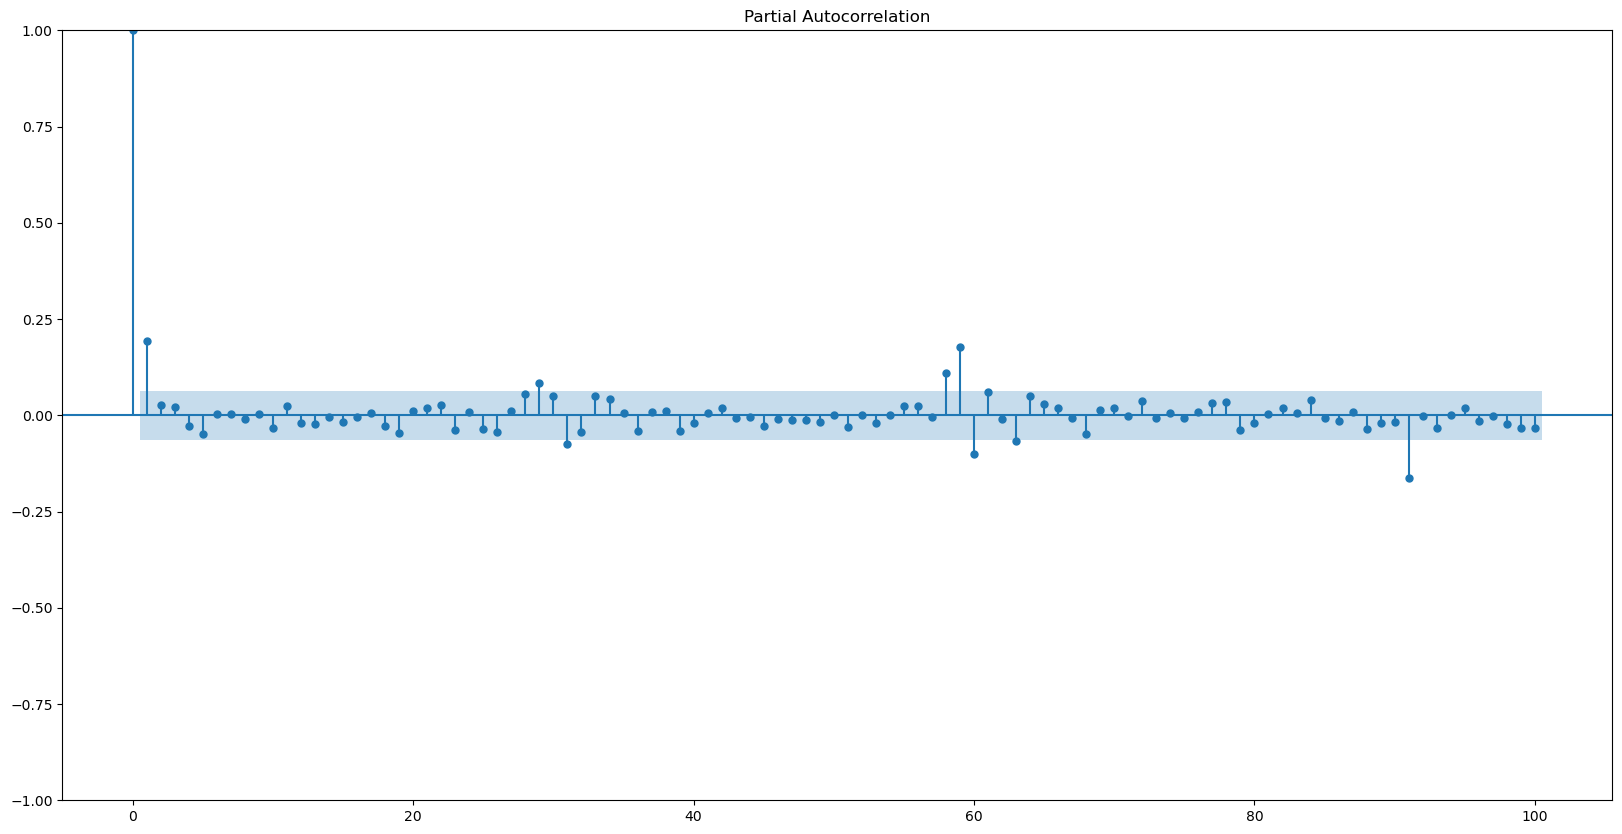

In [61]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_pacf(e_cleaned, lags=100, ax=ax)
plt.show()

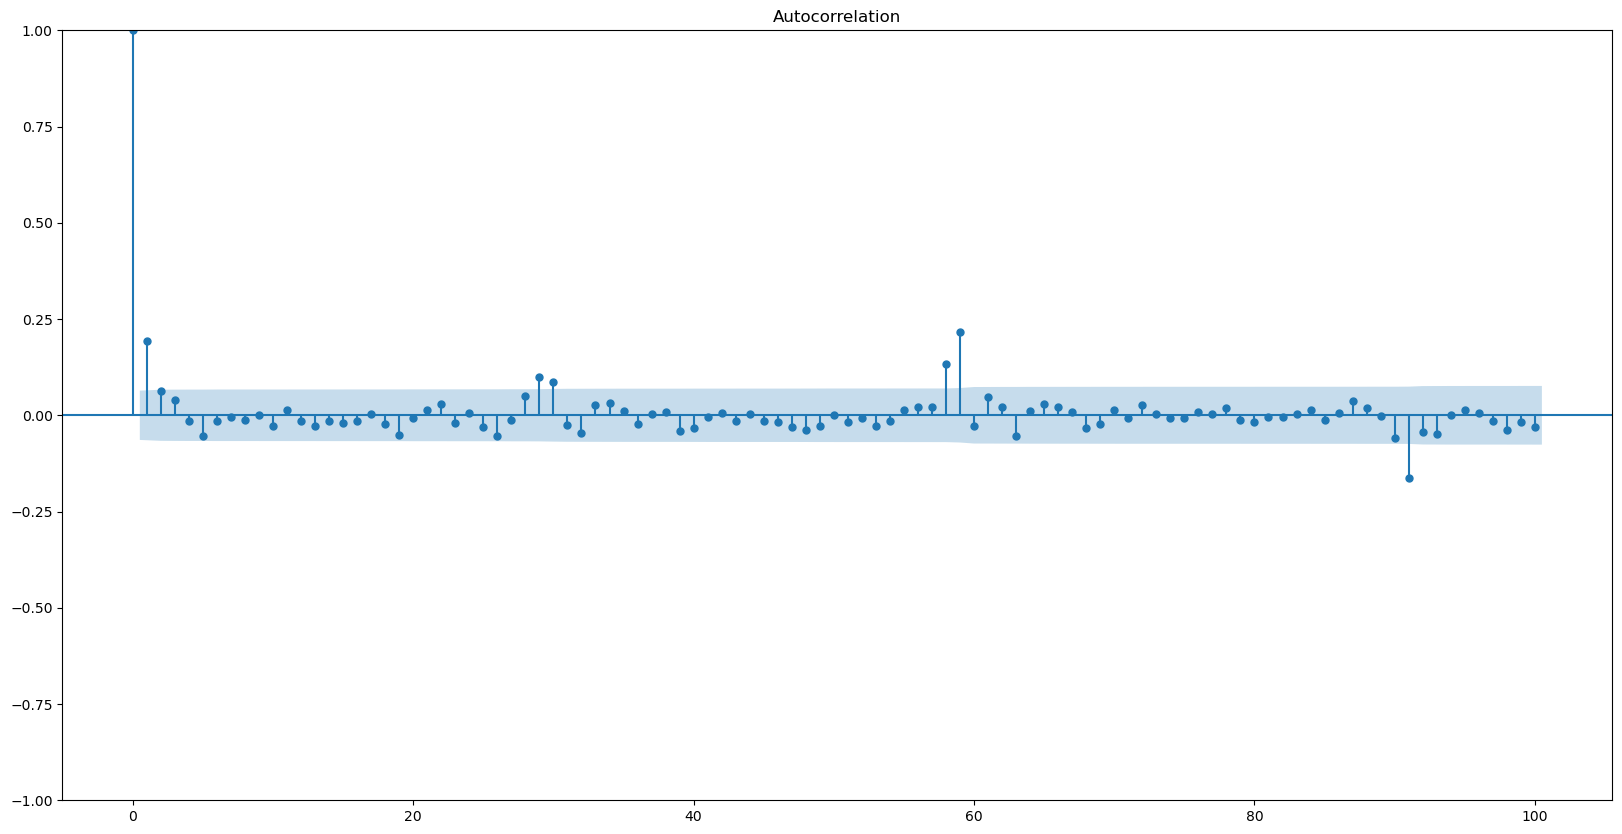

In [62]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_acf(e_cleaned, lags=100, ax=ax)
plt.show()

___
Как видно, эта модель сильно лучше обрабатывает месячную сезонность, так как автокорреляция меньше, однако она все равно есть

In [63]:
lb_test = acorr_ljungbox(e_cleaned, lags=[30, 60, 90], return_df=True)

print(lb_test)

       lb_stat     lb_pvalue
30   73.521923  1.613786e-05
60  153.588839  3.779456e-10
90  170.559176  6.325439e-07


#### Результаты теста Льюнга-Бокса:

- **Для 30 лагов:**
  - Статистика теста `lb_stat` равна 79.58.
  - P-значение `lb_pvalue` рачто значительно меньше 0.05. Это указывает на наличие автокорреляции в ряде остатков на 30 лагах.

- **Для 60 лагов:**
  - Статистика теста `lb_stat` равна 159.62.
  - P-значение `lb_11, что также значительно меньше 0.05. Это подтверждает наличие автокорреляции в ряде остатков на 60 лагах.

- **Для 90 лагов:**
  - Статистика теста `lb_stat` равна 176.41.
  - P-значение , что снова значительно меньше 0.05. Это указывает на наличие автокорреляции в ряде остатков на 90 лагах.


#### Сравнение моделей

##### Визуальный анализ (0.2 балла)

Визуализируйте прогнозы STL, ETS и тестовые значения на графике. Добавьте небольшой отрезок тренировочных данных, так получится более приятный график. Сравните метрики прогнозов. Какая из двух моделей получилась лучше? Как думаете, почему? 

In [64]:
y_test_ets = y_val
y_test_stl = y_pred_original

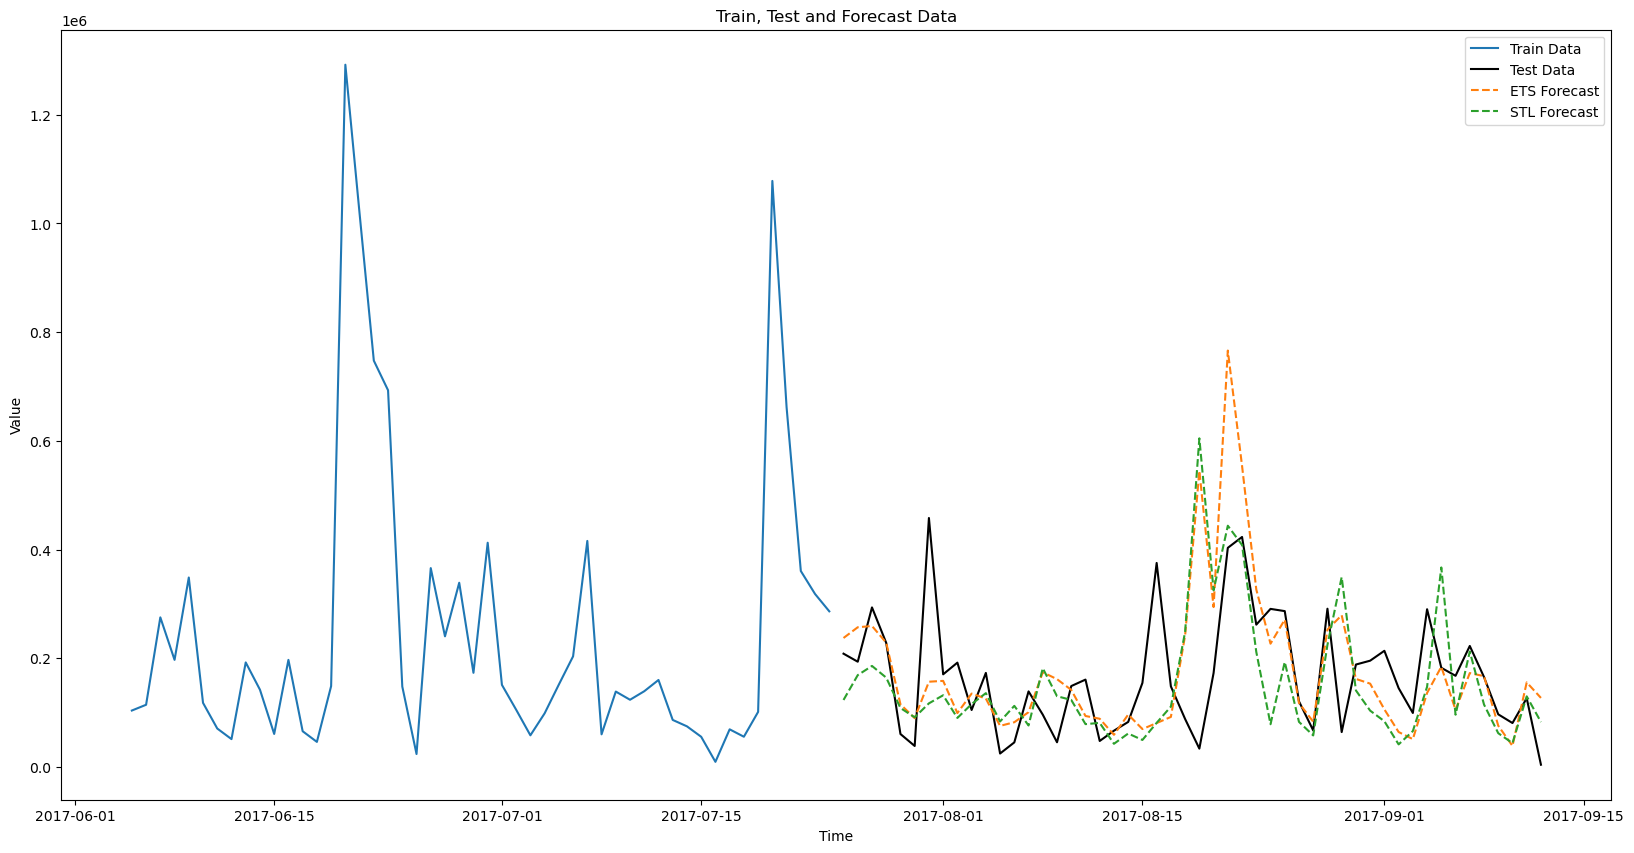

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plt.plot(Y_train.iloc[-50:].index, Y_train.iloc[-50:], label='Train Data')

plt.plot(Y_test.index, Y_test, label='Test Data', color='black')

plt.plot(Y_test.index, y_test_ets, label='ETS Forecast', linestyle='--')

plt.plot(Y_test.index, y_test_stl, label='STL Forecast', linestyle='--')

plt.legend()

plt.title('Train, Test and Forecast Data')
plt.xlabel('Time')
plt.ylabel('Value')


plt.show()


___
Судя по MAE, ETS справляется лучше, однако судя по графику и степени угадывания движений целевой переменной, можно, сказать, что STL справилась как минимум не хуже. Вероятно, это может быть связано с тем, что в наших данных присутсвует цикличность и зависимость от экзогенных переменных, которые частично учитывались при прогнозировании остатков в STL

##### Сравнение  моделей (0.65 балла)

(0.2 балла) Возьмите бенчмарк в виде сезонной наивной модели, подобрав период сезонности. Постройте прогноз такой модели на тест и подсчитайте MAE. Преодолела ли хотя бы одна модель этот бенчмарк?

In [66]:
y_naive = np.array( ( list(Y_train[-60:]['target']) * (50 // len(Y_train[-60:]) + 1))[:50] )

mae_benchmark = mean_absolute_error(Y_test, y_naive)
print(f"MAE for Seasonal Naive Model: {mae_benchmark}")

MAE for Seasonal Naive Model: 175708.0


___
Все модели выиграли у наивной. Ура. Но опережение не сильное

(0.15 балла за каждый корректно проведённый тест)

Проведите односторонний тест Диболда-Мариано для всех трёх возможных пар моделей. STL против ETS, STL против сезонной наивной, ETS против сезонной наивной. Нулевую гипотезу выберите самостоятельно, но тест должен быть односторонним. Готовую функцию с семинара используйте только для расчёта статистики, p-value подсчитайте для ваших гипотез самостоятельно. Проинтерпретируйте результаты всех трёх тестов. 

In [67]:
from scipy.stats import t
import numpy as np

def dm_test(actual_lst, pred1_lst, pred2_lst, h=1, crit="MSE"):
    T = len(actual_lst)
    
    if crit == "MSE":
        e1 = [actual_lst[i] - pred1_lst[i] for i in range(T)]
        e2 = [actual_lst[i] - pred2_lst[i] for i in range(T)]
        d = [e1[i]**2 - e2[i]**2 for i in range(T)]
    elif crit == "MAE":
        e1 = [abs(actual_lst[i] - pred1_lst[i]) for i in range(T)]
        e2 = [abs(actual_lst[i] - pred2_lst[i]) for i in range(T)]
        d = [e1[i] - e2[i] for i in range(T)]

    DM_stat = np.mean(d) / np.sqrt((1/(T-h)) * np.var(d, ddof=1))
    p_val = t.cdf(DM_stat, df=T - 1)

    return DM_stat, p_val


In [68]:
DM_stat, p_val = dm_test(list(Y_test['target']), list(y_test_stl), list(y_test_ets), crit="MSE")
print(f"STL vs ETS: DM_stat = {DM_stat}, p_val = {p_val}")

DM_stat, p_val = dm_test(list(Y_test['target']), list(y_test_stl), list(y_naive), crit="MSE")
print(f"STL vs Seasonal Naive: DM_stat = {DM_stat}, p_val = {p_val}")

DM_stat, p_val = dm_test(list(Y_test['target']), list(y_test_ets), list(y_naive), crit="MSE")
print(f"ETS vs Seasonal Naive: DM_stat = {DM_stat}, p_val = {p_val}")

STL vs ETS: DM_stat = 0.6295407673108205, p_val = 0.7340402055827558
STL vs Seasonal Naive: DM_stat = -2.0089787688630323, p_val = 0.025032709228451633
ETS vs Seasonal Naive: DM_stat = -2.003982146943758, p_val = 0.025308170086596186


#### Результаты теста Диболда-Мариано:

- **STL против ETS:**
  - Интерпретация: Нет статистически значимой разницы в точности прогнозов между моделью STL и ETS. Нельзя утверждать, что одна модель значимо лучше другой.

- **STL против сезонной наивной:**
  - Интерпретация: Модель STL значимо лучше сезонной наивной модели в точности прогнозов на уровне значимости 0.05.

- **ETS против сезонной наивной:**
  - Интерпретация: Модель ETS значимо лучше сезонной наивной модели в точности прогнозов на уровне значимости 0.05.

Исходя из результатов теста, модели STL и ETS обе показали лучшую точность прогнозов по сравнению с сезонной наивной моделью, в то время как между STL и ETS значимых различий не обнаружено.


##### Что бы вы сделали, будь у вас неприлично много денег? (0.05 балла)

P.S. Ваш семинарист хотел бы слетать в космос.
Я бы выкупил большой участок земли, возможно, никому не нужный остров и там бы сделал свое государство

##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/w3sV453spERTbGvr7